In [4]:
import os

from kloppy import sportec
import pandas as pd
from tqdm import tqdm

import pandas as pd
import numpy as np
root_path = "../../../rdf/sp161/shared/soccer-decision-making-r/sportec"
game = "DFL-MAT-J03YM3.xml"


In [5]:
event = sportec.load_event(
        event_data= f"{root_path}/event/{game}",
        meta_data=f"{root_path}/match_information/{game}",
        coordinates="sportec",
        event_types=["pass"],
    ).to_df()

event['event_id'] = event['event_id'].astype(int)
event['match_id'] = game
# tracking = sportec.load_tracking(
#         raw_data= f"{root_path}/tracking/xml/{game}",
#         meta_data=f"{root_path}/match_information/{game}",
#         sample_rate=1,
#         coordinates="sportec",
#         only_alive=False,
#     ).to_df()

In [7]:
event[event['event_id']== 18482700000032]

,event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,set_piece_type,result,success,match_id
14,18482700000032,PASS,1,0 days 00:00:49.007000,None,alive,None,DFL-CLU-000007,None,25.35,66.9,23.95,62.68,DFL-OBJ-0000O3,None,COMPLETE,True,DFL-MAT-J03YM3.xml


In [33]:
kpi_path = f"{root_path}/KPI_Merged_all/KPI_MGD_{game[:-4]}.csv"
kpi_df = pd.read_csv(kpi_path ,sep = ';', encoding='latin-1', on_bad_lines='skip')


In [34]:
kpi_df = kpi_df.drop_duplicates(subset = "FRAME_NUMBER").sort_values(by = "FRAME_NUMBER")
kpi_df['NEXT_FRAME'] = kpi_df['FRAME_NUMBER'].shift(-1)
kpi_df['NEXT_FRAME'] = kpi_df['NEXT_FRAME'].fillna(kpi_df['FRAME_NUMBER'].max())
kpi_df = kpi_df[kpi_df['NEXT_FRAME'] - kpi_df['FRAME_NUMBER'] >= 10]

In [35]:
import xml.etree.ElementTree as ET
def build_player_map(path): 
    tree = ET.parse(path) 
    root = tree.getroot() 
    data = {} 
    for root_elem in root.findall('.//Team'): 
        TeamId = root_elem.attrib.get('TeamId') 
        for elem in root_elem.findall('.//Player'): 
            data[elem.attrib.get('PersonId')] = TeamId 
    return data
player_map = build_player_map(f"/home/lz80/rdf/sp161/shared/soccer-decision-making-r/sportec/match_information/{game}")
player_map['BALL'] = 'BALL'
tracking['x_velo'] = tracking['ball_x'] - tracking['ball_x'].shift(-10)
tracking['y_velo'] = tracking['ball_y'] - tracking['ball_y'].shift(-10)

In [36]:
t = pd.merge(kpi_df, event[['event_id', 'result']], left_on = "EVENT_ID", right_on = "event_id")
t = t.sort_values(by = "FRAME_NUMBER")
oob_df = tracking[(abs(tracking['ball_x']) > (105/2 -.02)) | (abs(tracking['ball_y']) > (34 -.02))] #small tolerance for tracking issues

def get_rec(row, tracking):
    if not pd.isna(row['RECFRM']):
        return row['RECFRM']
    frame = row['FRAME_NUMBER']
    next_frame = tracking['frame_id'].max() if pd.isna(row['NEXT_FRAME']) else row['NEXT_FRAME']
    post_frame_track = tracking[(tracking['frame_id'] >= frame) & ((tracking['frame_id'] <= next_frame))].copy()
    if not pd.isna(row['PUID2']):
        #if we know the receiver, choose frame where receiver is closest
        recept_player = row['PUID2']
        post_frame_track['ball_dist'] = (post_frame_track['ball_x'] - post_frame_track[f'{recept_player}_x'])**2 + (post_frame_track['ball_y'] - post_frame_track[f'{recept_player}_y'])**2
        min_index = post_frame_track['ball_dist'].idxmin()
        print(post_frame_track.loc[min_index, 'frame_id'])
        return post_frame_track.loc[min_index, 'frame_id']
    if row['result'] == 'OUT':
        oob = oob_df[oob_df['frame_id'] >= frame]
        return oob['frame_id'].iloc[0]
    #else: perform 20 degree interception approach
    pass_x, pass_y = post_frame_track[post_frame_track['frame_id'] == frame][['x_velo', 'y_velo']].iloc[0].values

    p = np.array([pass_x, pass_y], dtype=float)
    p_norm = np.linalg.norm(p)

    v = post_frame_track[["x_velo", "y_velo"]].to_numpy(dtype=float)
    v_norm = np.linalg.norm(v, axis=1)
    dot = v @ p 
    cos_theta = dot / (v_norm * p_norm)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    post_frame_track["angle_deg"] = np.degrees(np.arccos(cos_theta))

    intercept_mask = (post_frame_track['angle_deg'] >= 20) | ((abs(post_frame_track['ball_x']) > (105/2 - .02))  | (abs(post_frame_track['ball_y']) > (34 - .02)))
    over_twenty = post_frame_track[intercept_mask]

    if over_twenty.shape[0] == 0:
        return min(row['NEXT_FRAME'], frame + 50, tracking['frame_id'].max())
    return over_twenty['frame_id'].iloc[0]

t['n_RECFRM'] = t.apply(lambda x: get_rec(x, tracking), axis = 1)
t= t[(t['n_RECFRM'] - t['FRAME_NUMBER']) >= 10]
#frames = pd.merge(t, blocks, on = 'FRAME_NUMBER')

#frames[['EVENT_ID', 'NEXT_FRAME_SAME_CLUB', 'NEXT_FRAME_DIFF_CLUB', 'FRAME_NUMBER']].sort_values(by = 'FRAME_NUMBER')

11720
11819
11951
14051
14327
15118
15923
16856
21360
22994
24175
26020
26331
26698
26786
28413
29001
29306
31051
32366
33524
34654
35677
36364
37171
37393
38707
41855
43393
43926
47890
48505
49058
50934
53806
53891
54165
55073
58548
58771
60340
62446
62587
63937
66877
67300
68081
68296
73308
73592
77510
78603
100328
100789
101070
101243
101430
101729
102708
103636
104083
107777
108238
108528
108754
108820
109637
112264
114072
114922
116411
116946
118239
118450


<positron-console-cell-36>:30: RuntimeWarning: invalid value encountered in divide
<positron-console-cell-36>:30: RuntimeWarning: invalid value encountered in divide
<positron-console-cell-36>:30: RuntimeWarning: invalid value encountered in divide


122158
125359
126308
126345
126397
127308
127942
128418
129061
129123
131188
132168
132306
132469
135514
138277
139535
139701
139851
141993
142028
143251
144545
146951
147721
148655
149698
150250
151453
151703
152350
156599
156658
157978
158617
159703
162284
163834
163899
164062
168329
169340
172110
173212
173577
173796
174030
175951


In [37]:
def tracking_wide_to_long(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts wide kloppy output of tracking data to more manageable long format

    Inputs:
        df - wide kloppy output
    Returns
        df in long format
    """
    track_cols = [c for c in df.columns if c.startswith("DFL-OBJ-") and c.count("_") >= 1]

    id_cols = [c for c in df.columns if c not in track_cols]
    m = df.melt(
        id_vars=id_cols,
        value_vars=track_cols,
        var_name="var",
        value_name="value"
    )

    obj_metric = m["var"].str.rsplit("_", n=1, expand=True)
    m["object_id"] = obj_metric[0]
    m["metric"] = obj_metric[1]

    m = m.drop(columns=["var"])

    print(m)
    print([c for c in id_cols if m[c].isna().any()])
    long_df = (
        m.pivot_table(
            index=id_cols + ["object_id"],
            columns="metric",
            values="value",
            aggfunc="first" 
        )
        .reset_index()
    )
    print(long_df)

    long_df.columns.name = None

    return long_df

def add_ball_rows(df_wide: pd.DataFrame, players_long: pd.DataFrame) -> pd.DataFrame:
    """
    Replaces ball columns with its own designated row in the tracking data to avoid unnecessary duplicates
    """
    key_cols = ["period_id", "timestamp", "frame_id", "ball_state", "ball_owning_team_id"]

    ball_long = (
        df_wide[key_cols + ["ball_x", "ball_y", "ball_z", "ball_speed"]]
        .rename(columns={"ball_speed": "s"})
        .assign(
            object_id="BALL",
            x=lambda d: d["ball_x"],
            y=lambda d: d["ball_y"],
            z=lambda d: d["ball_z"],
        )
        .drop(columns=["ball_x", "ball_y", "ball_z"])
    )

    out = pd.concat([players_long, ball_long], ignore_index=True, sort=False)
    return out.drop(columns = ["ball_x", "ball_y", "ball_z", "ball_speed"])

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mplsoccer import Pitch

def animate_event(
    tracking,
    ball_id="BALL",
    frame_col="frame_id",      # or "timestamp"
    pitch_length=105,
    pitch_width=68,
):
    """
    Create an animation of a tracking event.

    tracking: pd.DataFrame with columns [frame_col, team, x, y]
              one row per entity per frame.
    save_path: if provided, saves animation to mp4/gif (based on extension).
    Returns: (fig, anim)
    """
    teams = tracking["team"].unique()
    team1_id, team2_id = teams[teams != "BALL"]
    # Unique frames in order
    frames = np.sort(tracking[frame_col].unique())

    # Pitch setup
    pitch = Pitch(
        pitch_type="custom",
        pitch_length=pitch_length,
        pitch_width=pitch_width
    )
    fig, ax = pitch.draw()

    # Create empty scatter artists once (then update their offsets each frame)
    scat_t1 = pitch.scatter([], [], ax=ax)
    scat_t2 = pitch.scatter([], [], ax=ax)
    scat_ball = pitch.scatter([], [], ax=ax)

    # Style them
    scat_t1.set_color("blue")
    scat_t2.set_color("red")
    scat_ball.set_color("black")

    # Optional: nicer sizing
    scat_t1.set_sizes([40])
    scat_t2.set_sizes([40])
    scat_ball.set_sizes([25])

    # If you want frame label on plot
    title = ax.set_title("")

    def to_pitch_xy(df):
        # Your original code shifts coords from centered to pitch coords
        x = df["x"].to_numpy() + pitch_length / 2
        y = df["y"].to_numpy() + pitch_width / 2
        return np.column_stack([x, y])

    def init():
        scat_t1.set_offsets(np.empty((0, 2)))
        scat_t2.set_offsets(np.empty((0, 2)))
        scat_ball.set_offsets(np.empty((0, 2)))
        title.set_text("")
        return scat_t1, scat_t2, scat_ball, title

    def update(i):
        fr = frames[i]
        f = tracking[tracking[frame_col] == fr]

        t1 = f[f["team"] == team1_id]
        t2 = f[f["team"] == team2_id]
        ball = f[f["team"] == ball_id]
        scat_t1.set_offsets(to_pitch_xy(t1) if len(t1) else np.empty((0, 2)))
        scat_t2.set_offsets(to_pitch_xy(t2) if len(t2) else np.empty((0, 2)))
        scat_ball.set_offsets(to_pitch_xy(ball) if len(ball) else np.empty((0, 2)))

        title.set_text(f"{frame_col}: {fr}")
        return scat_t1, scat_t2, scat_ball, title

    anim = FuncAnimation(
        fig,
        update,
        frames=len(frames),
        init_func=init,
        blit=True
    )


    return fig, anim




11878 11961.0 INCOMPLETE Pass
       period_id              timestamp  frame_id ball_state ball_owning_team_id  ball_x  ball_y  ball_z  ball_speed  x_velo  y_velo  value       object_id metric
0              1 0 days 00:01:15.120000     11878      alive      DFL-CLU-000004    2.77   15.02    0.03       43.52    4.24   -4.41 -31.98  DFL-OBJ-0028OU      x
1              1 0 days 00:01:15.160000     11879      alive      DFL-CLU-000004    2.34   15.55    0.04       63.10    4.19   -4.23  -32.1  DFL-OBJ-0028OU      x
2              1 0 days 00:01:15.200000     11880      alive      DFL-CLU-000004    1.88   16.04    0.02       61.87    4.10   -4.09 -32.22  DFL-OBJ-0028OU      x
3              1 0 days 00:01:15.240000     11881      alive      DFL-CLU-000004    1.44   16.56    0.00       61.43    4.02   -3.93 -32.33  DFL-OBJ-0028OU      x
4              1 0 days 00:01:15.280000     11882      alive      DFL-CLU-000004    1.01   17.05    0.06       61.13    3.95   -3.74 -32.46  DFL-OBJ-0028OU

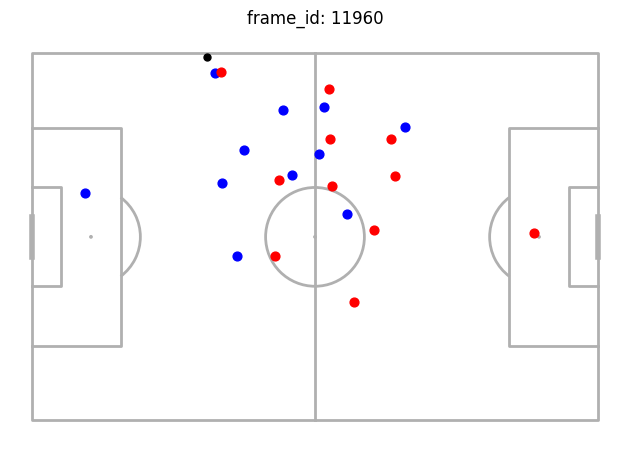

In [41]:
test = t[t['EVENT_ID'] == 18477700000031]
ooi = test[pd.isna(test['RECFRM'])][['FRAME_NUMBER', 'n_RECFRM', 'result', 'SUBTYPE']]
idx = 0
roi = ooi.iloc[idx]
start, end, result, subtype = [roi['FRAME_NUMBER'], roi['n_RECFRM'] + 10, roi['result'], roi['SUBTYPE']]
print(start, end, result, subtype)


event_t = tracking[tracking['frame_id'].isin(range(int(start), int(end)))]
c_frame = tracking_wide_to_long(event_t)
c_frame_ball = add_ball_rows(event_t, c_frame)
c_frame_ball['team'] = c_frame_ball['object_id'].map(player_map)
c_frame_ball = c_frame_ball[pd.notna(c_frame_ball['x'])]

fig, anim = animate_event(c_frame_ball, frame_col="frame_id")
from IPython.display import HTML
HTML(anim.to_jshtml())